In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from string import punctuation
from keras.preprocessing import sequence
from tensorflow import keras
from keras import models
from keras import layers
import string


<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

<a id="1"></a> <br>
# 3. Data Preparation

In [4]:
df_train.sample(5)

,id,keyword,location,text,target
2205,3159,deluge,"London, England",I apologise sincerely for the inevitable delug...,0
6460,9242,sunk,mainly California,why wasn't this warship sunk? CNN: First ...,1
4779,6800,loud%20bang,Kenya,tkyonly1fmk: Breaking news! Unconfirmed! I jus...,0
5299,7569,outbreak,"Los Angeles, CA",Families to sue over Legionnaires: More than 4...,1
2004,2880,damage,Austin | San Diego,@swb1192 if the NDA is written to damage your ...,0


In This work, we only need the text of each tweet and its label target. Therefore, we will drop the rest of features:

In [5]:
df_train.drop(['id','keyword','location'],axis=1,inplace=True)
df_test.drop(['keyword','location'],axis=1,inplace=True)

In [6]:
df_train.sample(5)

,text,target
5985,When you on the phone and @Worstoverdose screa...,0
56,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1
1102,70 years ago at this hour the USA A-bombed Hir...,1
216,*to Luka* They should all die! All of them! Ev...,0
4680,@MartinMJ22 @YouGov When did a 12 seat majorit...,1


We can create a column length in train_data, which will have length of each text.

<AxesSubplot:xlabel='target', ylabel='count'>

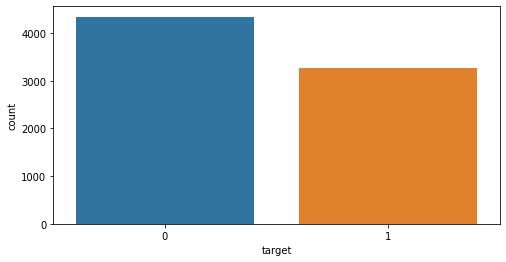

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(data = df_train, x = 'target')

In [8]:
df_train['length'] = df_train['text'].apply(len)
df_train.head()

,text,target,length
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


In [9]:
df_train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [10]:
df_train[df_train['length']==157].text.iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

Here the maximum length word is having repeated punctuations. So the important information delivered is very less.

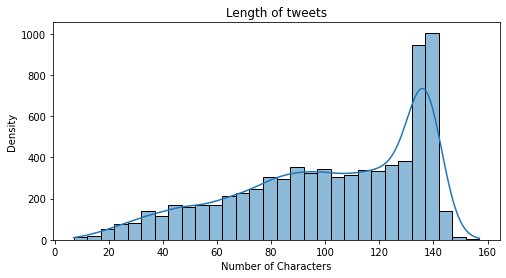

In [11]:
#Plotting tweets length
plt.figure(figsize=(8,4))
sns.histplot(data = df_train, x ='length',kde=True, bins=30)
plt.title('Length of tweets')
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

**Removing Punctuations:**

In [12]:
# string.punctuation will give the punctuations.
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We can create a function 'clean_text' to remove punctuations, and then it can used to clean text column of training data.

In [13]:
def clean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text 

Function 'clean_text', will remove punctuations in a text. Now we apply it to training data and create a column clean_text for the training data, which will have text without puntuations.

In [14]:
df_train['clean_text'] = df_train['text'].apply(clean_text)

In [15]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


In [16]:
#without apply 'clean_text function:
df_train.loc[1270,'text']

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

In [17]:
#after apply 'clean_text function:
df_train.loc[1270,'clean_text']

'when youre taking a shower and someone flushes the toilet and you have 1 second to GTFO or you get burned'

**Removing Noise:**

Noise in a text can be considered as anything which does belong to normal human language interaction.

Noise in the text can generally be considered as URL, abbreviations, emojis, message inside HTML tag, etc. Punctuations can also be considered as noise. But here we have already removed punctuations.

The main reason why abbreviations are included as noise is that some people write thx for thankyou. If abbreviations are not replaced with the original word, 'thx' and 'thankyou' will be considered as two different words.


In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [19]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [20]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

Function clean_tweet() will remove all the noise in the text.

In [21]:
df_train["clean_text"] = df_train["clean_text"].apply(clean_tweet)

In [22]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,65,NUMBER people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


**Removing Stopwords:**

Stopwords are commonly used words, which do not have any distinguishing features, like "a", "an", "the", so on… and search engine is programmed to ignore them while indexing entries and while retrieving the results of a search query. It saves space in the database and decreases processing speed. 

Natural Language Toolkit(nlkt) in python has a list of stopwords stored in 16 different languages. It is a leading platform for building a python program to work with human language data.


In [23]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
def remove_stopwords(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [25]:
df_train["clean_text"] = df_train["clean_text"].apply(remove_stopwords)

In [26]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",1,65,"[NUMBER, people, receive, wildfires, evacuatio..."
4,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


**Lowercasing:**

Lowercasing is a preprocessing method in which the text is converted into the lower case. In tokenization, Keras tokenizer is used, which will be converting texts to lowercase.

So here there is no need for lowercasing the texts as it will be a duplicate work.


**Tokenization:**

Tokenization generally decomposes text documents into small tokens and constructs a document word matrix. A document can be considered as a bag of words. Collection of document is called Corpus.

In document word matrix :

* Each Row represents a document (bag of words)
* Each column distinct token
* Each cell represents the frequency of occurrence of the token

Here Keras Tokenizer() is used which is supported by Tensorflow as a high-level API that encodes the token to a numerical value. The main reason to use this is in LSTM input is provided by embedding layer, which requires input data to be integer encoded.

Parameter 'num_words' can be used to restrict the number of the token to considered by the model.

Tokenizer() uses fit_on_texts() and texts_to_sequences() to encode the texts to numerical values.

* Fit_on_texts() Updates internal vocabulary based on a list of texts. It will create a dictionary with word mapping with an index (unique numerical value). Here all the words will be in lower case and the least value of index will be the more frequent word.

* texts_to_sequences() Transforms each text in texts to a sequence of numerical value. It will give assign the index of each to the word. So the output will be series of numerical values.



In [27]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",1,65,"[NUMBER, people, receive, wildfires, evacuatio..."
4,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


In [28]:
vocab_size = 23000
tokenizer = Tokenizer(num_words = vocab_size, split='')
tokenizer.fit_on_texts(df_train['clean_text'].values)
X = tokenizer.texts_to_sequences(df_train['clean_text'].values)
X = pad_sequences(X)

We are not be having the same length for all the sentences and while providing input to neural networks, we should have the same dimension for all inputs. So pad_sequence() is used to pad the input so that all the inputs have the same dimension. It will add zeros to the input, in the beginning, to make sure all the inputs have the same dimension.

In [29]:
X.shape

(7613, 25)

Here size of tokenized vector is 20, it is the maximum length of clean_text considering excluding those tokens which does not belong to top 3000 tokens. That is if the maximum length of clean_text is 35, then the 15 token will not be qualified to come under top 3000 tokens.

We can restrict on enhance dimension of tokenized vector by providing a parameter maxlen to pad_sequence().


<a id="1"></a> <br>
# 4. Modeling Using LSTM

In [30]:
y = df_train.target

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

**Embedding Layer:**



Embedding layer is the first layer of neural network and it has 3 parameters:

* input_dim: Number of distinct token vector, here it will be 3000 (max_features)
* output_dim: Dimension of embedding vector, we can take 32 dimension
* input_length: Size of input layer

Here embedding layer of size will be (3000, 32).


In [32]:
embed_dim = 32
lstm_out = 32
model = models.Sequential()
model.add(layers.Embedding(vocab_size,embed_dim,input_length=X.shape[1]))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units = lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-08-06 19:44:19.848505: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 32)            736000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 744,353
Trainable params: 744,353
Non-trainable params: 0
_________________________________________________________________


**Activation Function of Dense layer:**, i.e, is output layer is taken as Sigmoid function is taken as it is good at binary classification and our target column have value either 0 or 1.

**Dropout :** It is added to avoid overfitting.

**Loss Function :** The cross-entropy loss function is an optimization function that is used in the case of training a classification model and binary_crossentropy function computes the cross-entropy loss between true labels and predicted labels.

**optimizer :** Adam is used as optimizer which is replacement optimization algorithm for stochastic gradient descent for training deep learning models. Default learning rate of Adam is 0.001, but here I have initialized it to 0.002.



In [34]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, validation_data=(X_test,y_test))

2022-08-06 19:44:20.292546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
191/191 [==============================] - 13s 47ms/step - loss: 0.5928 - accuracy: 0.6793 - val_loss: 0.4631 - val_accuracy: 0.7951
Epoch 2/15
191/191 [==============================] - 8s 43ms/step - loss: 0.3292 - accuracy: 0.8658 - val_loss: 0.4620 - val_accuracy: 0.7886
Epoch 3/15
191/191 [==============================] - 8s 43ms/step - loss: 0.1789 - accuracy: 0.9332 - val_loss: 0.5549 - val_accuracy: 0.7879
Epoch 4/15
191/191 [==============================] - 8s 43ms/step - loss: 0.0965 - accuracy: 0.9680 - val_loss: 0.6687 - val_accuracy: 0.7623
Epoch 5/15
191/191 [==============================] - 8s 44ms/step - loss: 0.0591 - accuracy: 0.9816 - val_loss: 0.7781 - val_accuracy: 0.7649
Epoch 6/15
191/191 [==============================] - 9s 45ms/step - loss: 0.0400 - accuracy: 0.9880 - val_loss: 0.9052 - val_accuracy: 0.7663
Epoch 7/15
191/191 [==============================] - 8s 44ms/step - loss: 0.0314 - accuracy: 0.9913 - val_loss: 0.8234 - val_accuracy: 0.749

<a id="1"></a> <br>
# 5. Evaluation

In [35]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

In [36]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

191/191 [==============================] - 2s 9ms/step - loss: 0.0080 - accuracy: 0.9969
Accuracy of the model on Training Data is -  99.68801140785217 %
48/48 [==============================] - 0s 9ms/step - loss: 0.9975 - accuracy: 0.7413
Accuracy of the model on Testing Data is -  74.13000464439392 %


In [37]:
y_pred = model.predict(X_test).round()

In [38]:
def measure(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    f1 = round(f1_score(y_true, y_pred),4)
    return pd.Series({'accuracy_score':accuracy,
                     'recall_score':recall,
                     'precision_score':precision,
                     'f1_score':f1})

In [39]:
measure(y_test, y_pred)

accuracy_score     0.7413
recall_score       0.6487
precision_score    0.7172
f1_score           0.6812
dtype: float64

In [40]:
con = confusion_matrix(y_test,y_pred)

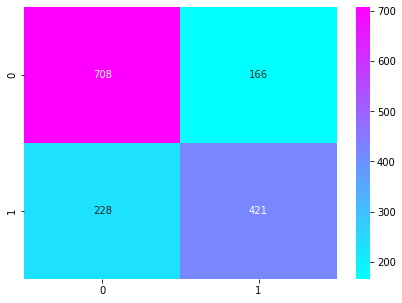

In [41]:
plt.figure(figsize=(7, 5))
sns.heatmap(con, annot=True, fmt='d', cmap='cool')
plt.show()

**As Accuracy, Precision, recall and F1 score are above 70 % this model can be considered as good model.**

**By changing dimension on Embedding Layer, vocab_size, LSTM can check if the evalution factors are improving or not.**


<a id="1"></a> <br>
# 6. Submission

For submission stopwords are not removing, as words like 'not' has a major role in distinguishing disaster and non-disaster tweet.

In [42]:
df_test['clean_text'] = df_test['text'].apply(clean_text)

df_test["clean_text"] = df_test["clean_text"].apply(clean_tweet)

In [43]:
df_test['clean_text'].head()

0                  Just happened a terrible car crash 
1    Heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3               Apocalypse lighting Spokane wildfires 
4    Typhoon Soudelor kills NUMBER in China and Tai...
Name: clean_text, dtype: object

In [44]:
vocab_size = 23000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_test['clean_text'].values)
X = tokenizer.texts_to_sequences(df_test['clean_text'].values)
X = pad_sequences(X)

In [45]:
y_hat = model.predict(X).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.431811
std,3146.427221,0.495404
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
